# Attention background

## Distributional Hypothesis

> **Words that occur in similar contexts tend to have similar meanings**.  This link between similarity in how words are distributed and similarity in what they mean is called the **distributional hypothesis**. The hypothesis was first formulated in the 1950s by linguists like Joos (1950), Harris (1954), and Firth(1957), who noticed that *words which are synonyms (like oculist and eye-doctor) tended to occur in the same environment* (e.g., near words like eye or examined) with the amount of meaning difference between two words “corresponding roughly to the amount of difference in their environments” (Harris, 1954, 157).

## Transformer goal

> The intuition of a transformer is that across a series of layers, we build up richer and richer contextualized representations of the meanings of input words or tokens [...]. At each layer of a transformer, to compute the representation of a  word i we combine information from the representation of i at the previous layer with information from the representations of the neighboring words[...]. **The goal is to  produce a contextualized representation for each word at each position.**

## Example relationships between words to determine meaning
-  The **keys** to the cabinet **are** on the table -> Subject verb agreement
-  **The chicken** crossed the road because **it** wanted to get to the other side. -> Pronoun *it* refers to *The chicken*. 
- Necesito un **sobre** para poder **enviar** mis **documentos**. -> *Documentos* y *enviar* son determinantes en el significado de sobre como un contenedor en lugar de la preposición *Encima de*.

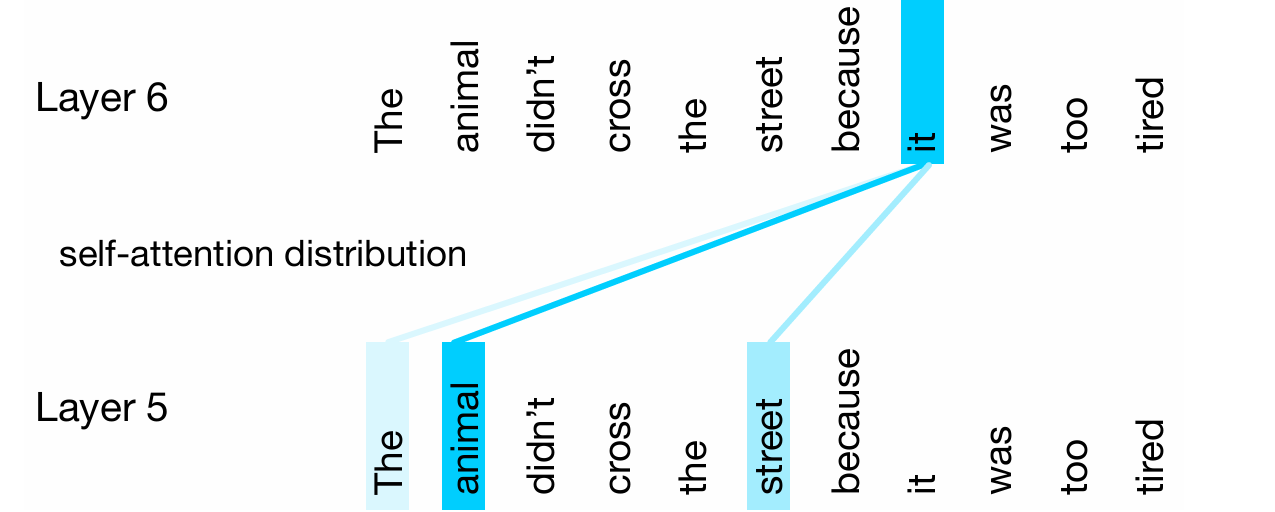


## Backward looking Attention steps 

### First version

1. **Create vector representations for a tokenized sequence of length $N$**: 

$$x_1, x_2, \cdots, x_N \in \mathbb{R}^{1 \times d}$$

2. **Compare representation similarity with respect to x_i (the current focus of attention)**: 

$$ score(x_i, x_j) := x_i \cdot x_j  $$
$$ s_{ij} := score(x_i, x_j)$$

3. **Normalize the scores with a softmax to indicate the proportional relevance of each input to the the current focus of attention:**
$$ a_{ij} = softmax(s_{ij}) \quad \forall j \leq i$$
$$ a_{ij} = \frac{\exp{s_{ij}}}{\sum_{k=1}^{i} \exp(s_{ik})} \quad \forall j \leq i$$

4. **Create new representation using normalized scores:**

$$ y_i = \sum_{j \leq i} a_{ij} x_i $$

> The core of an attention-based approach: a set of comparisons to relevant items in some context, a normalization of those scores to provide a probability distribution, followed by a weighted sum (linear combination) using this distribution.

**Notice**: Each vector $x_k$, $k = 1, \cdots, N$ has three different roles: 
1. **Center of attention (key):** $x_i$
2. **Element of comparison (query):** $x_j, j \leq i$
3. **Retrieved value (value)**: $ y_i = \sum_{j \leq i} a_{ij} x_i $

#### Side note: Key, query and value inspiration from information retrieval

We formulate a search instruction (i.e. a query) that contains the relevant information:

> I'm looking for the book **Harry Potter and the Chamber of Secrets**

We compare our query parameters(the name) with each of the possible book names available (the keys): 

<img src="https://www.goalexandria.com/wp-content/uploads/2018/07/DSC_0186.jpg" style="width: 500px">

Our comparison is boolean: either we have the book that we want or not. Once we found what we were looking for, we retrieve the book itself (the value), and not its name. 

### Second version:

1. **Create vector representations for a tokenized sequence of length $N$**: 

$$ q_i = x_i W^Q, k_i = x_i W^K, v_i = v_i W^V \, \forall i$$

where

$$ W^Q, W^K \in \mathbb{R}^{d \times d_k}, W^V \in \mathbb{R}^{d \times d_v} $$

2. **Compare representation similarity with respect to q_i** (and prevent overflow dividing by $\sqrt{d_k}$): 

$$ score(x_i, x_j) := \frac{q_i \cdot k_j}{\sqrt{d_k}}  $$
$$ s_{ij} := score(x_i, x_j)$$

3. **Normalize the scores with a softmax to indicate the proportional relevance of each input to the the current focus of attention:**
$$ a_{ij} = softmax(s_{ij}) \quad \forall j \leq i$$
$$ a_{ij} = \frac{\exp{s_{ij}}}{\sum_{k=1}^{i} \exp(s_{ik})} \quad \forall j \leq i$$

4. **Create new representation using normalized scores:**

$$ y_i = \sum_{j \leq i} a_{ij} v_i $$

### Final parallelized version

Let $X$ be the matrix containing the embeddings of each token in the sequence: $X \in \mathbb{R}^{N \times d}$. Use this matrix to produce

$$ Q = XW^Q \in \mathbb{R}^{N \times d_k} $$
$$ K = XW^K \in \mathbb{R}^{N \times d_k} $$
$$ V = XW^V \in \mathbb{R}^{N \times d_v} $$

Finally:

$$ A = SelfAttention(Q, K, V) = softmax \left( \frac{QK^T}{\sqrt(d_k)} \right) V$$ 

> Note: In backward looking attention we need to do future masking, i.e. make the scores of future words be 0. 



# Attention implementation

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
from math import sqrt 

## Word tokenization and indexing

In [2]:
def create_token_vocab(documents: list) -> list:
    """
    Creates a token vocabulary (in this case we take tokens to be equivalent to words) from a list of documents and 
    a dictionary that associates each word with an index.  

    Parameters
    ----------
    documents : list
        List of strings from which to build the token vocabulary. 
    Returns
    -------
    list
        List of lowercase tokens without repetition.  
    dict
        Dictionary of words in the vocabulary as keys and their corresponding index as value
    """
    vocab = set()
    for doc in documents:
        words = doc.lower().split()
        vocab.update(set(words))
    vocab = list(vocab) #so that we can get words from indexes
    word2ind = {word: index for index, word in enumerate(vocab)}
    
    return vocab, word2ind
        

In [4]:
class Tokenizer:
    def __init__(self, documents):
         self.vocab, self.word2ind = create_token_vocab(documents)
         
    def tokenize(self, doc):
        return [self.word2ind[word] for word in doc.lower().split()] #return the associated ids
    
    def convert_ids_to_tokens(self, ids):
        return [self.vocab[id] for id in ids] #return the original tokens from a list of ids

In [7]:
#Process of creation of input ids
doc1 = "This is an example text and a random ending"
doc2 = "This is another example text with more words and the random word test"
docs = [doc1, doc2]

tokenizer = Tokenizer(docs)
# print(tokenizer.word2ind)
ids = tokenizer.tokenize("This is a test text")
print(ids)

print(tokenizer.convert_ids_to_tokens(ids))

[7, 0, 4, 6, 5]
['this', 'is', 'a', 'test', 'text']


## Embedding creation

In [9]:
class Config:
    #Class to keep track of configuration parameters
    def __init__(self, embed_dim = 6, num_heads = 2, vocab_size = 10, token_limit = 5):
        self.embed_dim = embed_dim #dimension of word embeddings
        self.num_heads = num_heads #number of heads in multi-head attention
        self.vocab_size = vocab_size #token vocabulary size
        self.token_limit = token_limit #max number of tokens that we can process

In [10]:
config = Config()
config.vocab_size

10

In [64]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        #nn.Embedding creates a lookup table (i.e. a matrix) that stores vector embeddings of dimension d for a given vocabulary size V.
        d = config.embed_dim
        V = config.vocab_size
        self.token_limit = config.token_limit
        self.token_embeddings = nn.Embedding(V, d) 
        #Token limit is the max number of tokens that we can process
        self.position_embeddings = nn.Embedding(self.token_limit, d) #In this case we create a matrix of positional vector embeddings

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(0)
        assert seq_length <= self.token_limit #check if we are within the allowed token limits
        
        position_ids = torch.arange(seq_length, dtype=torch.long) 
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        
        return token_embeddings + position_embeddings # Combine token and position embeddings

## Attention

In [21]:
def scaled_dot_product_attention(Q, K, V, add_mask=True):
    """
    Implementation of the self-attention mechanism of a sequence of N tokens in matrix form: softmax(QK^T/sqrt(dim_k))V. 

    Parameters
    ----------
    Q : torch.tensor
        The query matrix: Q = X(W^Q)
    K : torch.tensor
        The key matrix: K = X(W^K)
    V : torch.tensor
        The value matrix: V = X(W^V)
    Returns
    -------
    torch.tensor
        Matrix of contextual representations of tokens
    """
    
    dim_k = K.size(-1) #Dimension of key and query vectors
    scores = torch.mm(Q, K.transpose(0, 1)) / sqrt(dim_k) #Matrix of dot products of query and key vectors
    if add_mask:
        N = Q.size(0) #Get the sequence length
        #torch.tril returns the lower triangular part of the matrix, the other elements of the result tensor out are set to 0.
        mask = torch.tril(torch.ones(N, N))
        scores = scores.masked_fill(mask == 0, float("-inf")) #fill 0 scores with -inf
    weights = F.softmax(scores, dim=-1) #Dim is the dimension along which softmax will be computed.
    print(weights)
    return torch.mm(weights, V)

In [24]:
X = torch.rand(3, 5)
print(X)
scaled_dot_product_attention(X, X, X, 1)

tensor([[0.8505, 0.4000, 0.3561, 0.2708, 0.9474],
        [0.6939, 0.9952, 0.3525, 0.0898, 0.2699],
        [0.1606, 0.4863, 0.0489, 0.7793, 0.2100]])
tensor([[1.0000, 0.0000, 0.0000],
        [0.4684, 0.5316, 0.0000],
        [0.3263, 0.3235, 0.3502]])


tensor([[0.8505, 0.4000, 0.3561, 0.2708, 0.9474],
        [0.7673, 0.7164, 0.3542, 0.1746, 0.5872],
        [0.5583, 0.6228, 0.2474, 0.3903, 0.4700]])

In [26]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()

        #Linear applies a linear transformation to the data: y = xA^T + b
        #The product is xA^t and not Ax because we take x to be a row vector or a matrix of row vectors
        
        #Project the embedding vector to a vector of dimension head_dim
        self.Wq = nn.Linear(embed_dim, head_dim, bias = False)
        self.Wk = nn.Linear(embed_dim, head_dim, bias = False)
        self.Wv = nn.Linear(embed_dim, head_dim, bias = False)

    def forward(self, X):
        attn_outputs = scaled_dot_product_attention(
            self.Wq(X), #The product XW^Q = Q
            self.Wk(X), #The product XW^K = K
            self.Wv(X)  #The product XW^V = V
          )
        return attn_outputs

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.embed_dim
        num_heads = config.vocab_size
        assert embed_dim % num_heads == 0 #Check if embed_dim is divisible by num_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, X):
        x = torch.cat([head(X) for head in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

## Attention visualization

In [26]:
#hide_output
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import GPT2Model
# from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

# model_ckpt = "bert-base-uncased"
model_ckpt = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = GPT2Model.from_pretrained(model_ckpt)
text = "time flies like an arrow"
# show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)
show(model, "gpt2", tokenizer, text, display_mode="light", layer=0, head=8)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>